In [1]:
#make sure you are a the report /TFM directory, then we will create the report folder
#if not, you can change the directory to /TFM with this code below.
import os
path = "here your path"
os.chdir(path)

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado: 'here your path'

In [2]:
import os
path = os.getcwd()
if path.endswith('TFM') == True:
    !mkdir imb_reports
    !mkdir bal_reports
    !mkdir smote_reports
else:
    print("Ensure that you are in the /TFM folder")

Ya existe el subdirectorio o el archivo imb_reports.
Ya existe el subdirectorio o el archivo bal_reports.
Ya existe el subdirectorio o el archivo smote_reports.


#### Import libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            explained_variance_score,recall_score,f1_score,precision_score,roc_curve,roc_auc_score,\
                            accuracy_score,confusion_matrix, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.svm import LinearSVC,SVC

from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split,cross_validate
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from plotly.subplots import make_subplots
import plotly.graph_objects as go
#import streamlit as st
import cufflinks as cf
cf.set_config_file(theme='pearl',sharing='public',offline=True)



pd.set_option('display.max_columns', None)
%matplotlib inline

In [4]:
# define the dataset location
# data will be located at root.
accidents = 'accidents_clean.csv'
cas_veh = 'df_merged_cat.csv'
path ='../../'

### Load data

In [5]:
#ORIGINAL DATA
#dfa = pd.read_csv('../../Descargas/Stats19-Data1979-2004/Accidents7904.csv',delimiter=',',encoding='UTF-8-SIG',index_col=0)

In [6]:
# load the accidents_clean_csv file as a dataframe
dfa = pd.read_csv(path + accidents,delimiter=',',encoding='UTF-8-SIG',index_col=0)

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [7]:
# load the casualty_vehicle_csv file as a data frame
dfm = pd.read_csv(path + cas_veh,delimiter=',',encoding='UTF-8-SIG',index_col=0)

In [8]:
#Rename the column which will be used to have a merge.
dfa.rename(columns = {'Accident_Index':'Acc_Index'}, inplace = True)

In [9]:
#Merge the Accidents, casualties and vehicles dataframes cleaned from the last notebook.
dfmerged = pd.merge(dfa,dfm,how='inner',on= 'Acc_Index')

In [11]:
df_imbalanced = dfmerged

In [12]:
#Drop useless columns
df_imbalanced.drop(columns=['Acc_Index', 'Number_of_Vehicles',
       'Number_of_Casualties', 'Date',
       'Road_Type','Month', 'Year', 'Hour','Speed_limit_2', 'Sex_of_Casualty',
       'Age_Band_of_Casualty', 'Casualty_Type','Propulsion_Code','1st_Road_Class'],inplace=True)

In [13]:
#delete old dataframes in order to have more RAM space
del dfa,dfm

### *Feature engineering*

In [14]:
## Processing numerical and categorical features.

In [15]:
def cat_num(data):
    for i in data.columns:
        if i == 'Age_of_Vehicle' or i == 'Engine_Capacity_(CC)':
            data[i] = data[i].astype('int64')
        else:
            data[i] = data[i].astype('str')
    return data

In [16]:
df_imbalanced = cat_num(df_imbalanced)

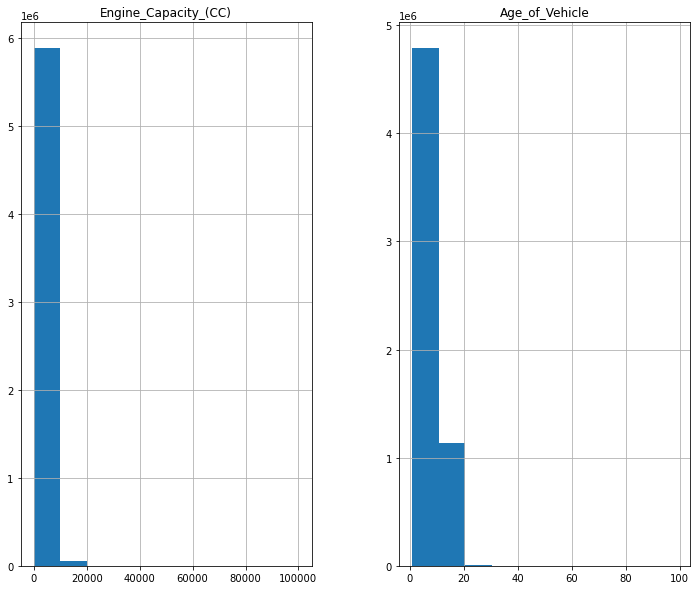

In [17]:
df_imbalanced.hist(figsize=(12,10));
#the two numerical variables doesn't have a normal distribution.
# We can also use a log tranform to check if the columns follow like a normal distribution

In [18]:
df_imbalanced['Age_of_Vehicle'] = df_imbalanced['Age_of_Vehicle'].replace(0,0.1)
df_imbalanced['Engine_Capacity_(CC)'] = df_imbalanced['Engine_Capacity_(CC)'].replace(0,0.1)
df_imbalanced['Age_of_Vehicle'] = df_imbalanced['Age_of_Vehicle'].apply(lambda x: np.log10(x))
df_imbalanced['Engine_Capacity_(CC)'] = df_imbalanced['Engine_Capacity_(CC)'].apply(lambda x: np.log10(x))

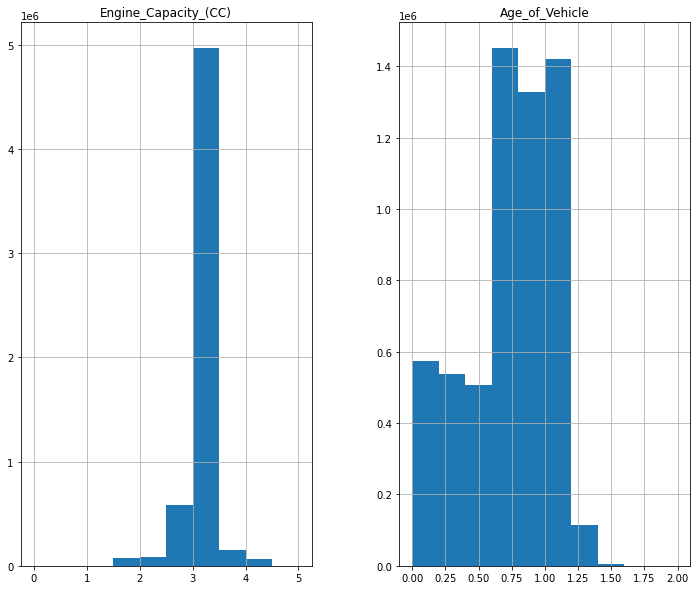

In [19]:
df_imbalanced.hist(figsize=(12,10));

In [303]:
# We can see that the distribution of Engine capacity and age of vehicle improves a little.

<AxesSubplot:xlabel='Engine_Capacity_(CC)'>

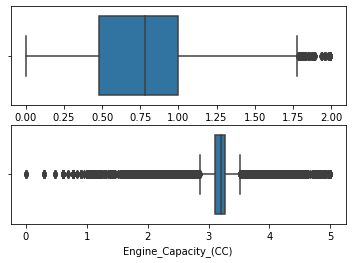

In [20]:
# plotting boxplots
fig,ax = plt.subplots(2,1)
sns.boxplot(data=df_imbalanced, x='Age_of_Vehicle',ax=ax[0])
sns.boxplot(data=df_imbalanced, x='Engine_Capacity_(CC)',ax=ax[1])


In [21]:
#The previous boxplot tell us that variable Engine_capacity have some outliers and don't have a good distribution
#we will probably we drop this column

In [22]:
#check for NaN and missing values
print('NaN',df_imbalanced.isna().sum()/len(df_imbalanced))
np.abs(df_imbalanced[df_imbalanced == -1].sum())/len(df_imbalanced)

NaN Accident_Severity            0.0
Day_of_Week                  0.0
Speed_limit                  0.0
Daytime                      0.0
Road_Surface_Conditions_2    0.0
Weather_Conditions_2         0.0
Light_Conditions_2           0.0
Vehicle_Type                 0.0
Sex_of_Driver                0.0
Age_Band_of_Driver           0.0
Engine_Capacity_(CC)         0.0
Age_of_Vehicle               0.0
dtype: float64


Accident_Severity            0.0
Day_of_Week                  0.0
Speed_limit                  0.0
Daytime                      0.0
Road_Surface_Conditions_2    0.0
Weather_Conditions_2         0.0
Light_Conditions_2           0.0
Vehicle_Type                 0.0
Sex_of_Driver                0.0
Age_Band_of_Driver           0.0
Engine_Capacity_(CC)         0.0
Age_of_Vehicle               0.0
dtype: object

In [23]:
df_imbalanced.dtypes

Accident_Severity             object
Day_of_Week                   object
Speed_limit                   object
Daytime                       object
Road_Surface_Conditions_2     object
Weather_Conditions_2          object
Light_Conditions_2            object
Vehicle_Type                  object
Sex_of_Driver                 object
Age_Band_of_Driver            object
Engine_Capacity_(CC)         float64
Age_of_Vehicle               float64
dtype: object

In [24]:
# Converting the target variable into numeric categories
df_imbalanced['Accident_Severity'].replace({'Slight': 1, 'Serious': 2, 'Fatal': 3}, inplace=True)
df_imbalanced['Accident_Severity'] = df_imbalanced['Accident_Severity'].astype('int64')

In [25]:
df_balanced = df_imbalanced

In [26]:
#We Selected a small part of the dataset in order to have a small wait time between fit and predict for every algorythm
df_imbalanced = df_imbalanced.sample(1000000)

In [27]:
df_imbalanced.Accident_Severity.value_counts(normalize=True)

1    0.790189
2    0.182068
3    0.027743
Name: Accident_Severity, dtype: float64

As we can see the dataset  is imbalanced. 

This is a real problem because the minority classes will report the worst score.

First I'm going to try with metrics like au_roc curve, f1score, 

recall and precision in order to check how good or bad is our

model before apply techniques for handling imbalance data.

In [28]:
#This function calculates the Variance inflation factor and operates to drop the columns which VIF is greater than 5. Then it drops the variables with high collinearity

# URL: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python

from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

In [29]:
def vtypes(data):
    cat = data.select_dtypes('object').columns
    num = data.select_dtypes('float64').columns
    return cat,num

In [30]:
cat,num = vtypes(df_imbalanced)

In [31]:
df_imbalanced.dtypes

Accident_Severity              int64
Day_of_Week                   object
Speed_limit                   object
Daytime                       object
Road_Surface_Conditions_2     object
Weather_Conditions_2          object
Light_Conditions_2            object
Vehicle_Type                  object
Sex_of_Driver                 object
Age_Band_of_Driver            object
Engine_Capacity_(CC)         float64
Age_of_Vehicle               float64
dtype: object

#### *Preprocessing*

In [32]:
#Labelencoder target and features
def lencoder(df_imbalanced):
    lenc = LabelEncoder()
    df_imbalanced[cat] = df_imbalanced[cat].apply(lenc.fit_transform)
    df_imbalanced['Accident_Severity'] = lenc.fit_transform(df_imbalanced['Accident_Severity'])
    return df_imbalanced

In [33]:
df_imbalanced = lencoder(df_imbalanced)

In [34]:
def target_features(data):
    X = data.drop('Accident_Severity', axis=1)
    y = data['Accident_Severity']
    return X,y

In [35]:
X,y = target_features(df_imbalanced)

In [36]:
#Drop the columns with high collinerarity
X=calculate_vif(X)

dropping 'Engine_Capacity_(CC)' at index: 9
dropping 'Vehicle_Type' at index: 6
dropping 'Age_Band_of_Driver' at index: 7
dropping 'Weather_Conditions_2' at index: 4
Remaining variables:
Index(['Day_of_Week', 'Speed_limit', 'Daytime', 'Road_Surface_Conditions_2',
       'Light_Conditions_2', 'Sex_of_Driver', 'Age_of_Vehicle'],
      dtype='object')


In [37]:
features_col = list(X.columns)
features_col

cat=[]
num=[]
for i in features_col:
    if i == 'Age_of_Vehicle' or i =='Engine_Capacity_(CC)':
        num.append(i)
    else:
        cat.append(i)

In [38]:
#split before train our model
def split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    return X_train, X_test, y_train, y_test

In [39]:
X_train, X_test, y_train, y_test = split(X,y)

#### *define our functions before evaluate our model*

In [40]:
#This functions allow us to make predictions using different models.
#folder selection
    #folder=1 for imb_reports
    #folder=2 for bal_reports
    #folder=3 for smote_reports

def fit_pred_mod(select_model,folder):
  #model selection 
    if select_model == 1:
        model = LogisticRegression(multi_class= "multinomial")
    elif select_model == 2:
        model = DecisionTreeClassifier()
    elif select_model == 3:
        model = RandomForestClassifier()
    elif select_model == 4:
        model = BaggingClassifier()
    elif select_model == 5:
        model = LinearSVC()
    elif select_model == 6:
        model = KNeighborsClassifier()
    elif select_model == 7:
        model = MLPClassifier()
    if folder == 1:
        folder = 'imb_reports'
    elif folder == 2:
        folder = 'bal_reports'
    elif folder == 3:
        folder = 'smote_reports'
        
    numeric_features = num
    categorical_features = cat
    #Handling categorical and numerical data with Pipelines
    numeric_transformer = Pipeline(steps=[
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

    #categorical_transformer = LabelEncoder()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')
    categorical_transformer  = StandardScaler()
    preprocessor = ColumnTransformer(
    transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),])
        
    
    clf = Pipeline(steps=[('preprocessor', preprocessor),
    ('classifier', model)])
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print(X_train.shape)
    eval_score(X_train, X_test, y_train, y_test, clf, yhat,select_model,folder)

In [41]:
def eval_score(X_train, X_test, y_train, y_test, classifier,yhat,select_model,folder):
  #  classifier.fit(X_train, y_train)
#    preds = classifier.predict(X_test)
#    probs = classifier.predict_proba(X_test)
    
    if select_model == 1:
        modelts = 'LogisticRegression'
    elif select_model == 2:
        modelts = 'DecisionTreeClassifier'
    elif select_model == 3:
        modelts = 'RandomForestClassifier'
    elif select_model == 4:
        modelts = 'BaggingClassifier'
    elif select_model == 5:
        modelts = 'LinearSVC'
    elif select_model == 6:
        modelts = 'KNeighborsClassifier'
    elif select_model == 7:
        modelts = 'MLPClassifier'
          
  
    n_class = 3
    print("model score: %.3f" % classifier.score(X_test, y_test))
    cr = classification_report(y_test, yhat)
    print(cr)
    
    f = open(folder+'/report_'+modelts+'.txt', 'w')
    f.write('Classification Report {}\n\n{}'.format(modelts ,cr))
    f.close()
    
    if select_model != 5:
        # roc curve for classes
        fpr = {}
        tpr = {}
        thresh ={}
        probs = classifier.predict_proba(X_test)
        for i in range(n_class):    
            fpr[i], tpr[i], thresh[i] = roc_curve(y_test, probs[:,i], pos_label=i)
        # plotting    
        plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 2 vs Rest')
        plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
        plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 0 vs Rest')
        plt.title('Multiclass ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')
        plt.legend(loc='best')
        plt.savefig(folder+'/'+ modelts+'Multiclass ROC',dpi=300);
        roc_auc_score(y_test, probs,multi_class='ovo', average='weighted')
    #plotting matrix confusion
    matrix = confusion_matrix(y_test, yhat)
    dataframe = pd.DataFrame(matrix, index=['Slight', 'Serious', 'Fatal'], 
                            columns=['Slight', 'Serious', 'Faltal'])
    # create heatmap
    fig,ax = plt.subplots()
    ax = sns.heatmap(dataframe, annot=True, cbar=None, cmap='Blues')
    ax = plt.title('Confusion Matrix')
    ax = plt.tight_layout(), plt.xlabel('True Values'), plt.ylabel('Predicted Values')
    plt.show()
    fig.savefig(folder+'/' + modelts +'Confusion Matrix',dpi=300);
    
    return

(750000, 7)
model score: 0.790


C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.79      1.00      0.88    197488
           1       0.00      0.00      0.00     45657
           2       0.00      0.00      0.00      6855

    accuracy                           0.79    250000
   macro avg       0.26      0.33      0.29    250000
weighted avg       0.62      0.79      0.70    250000



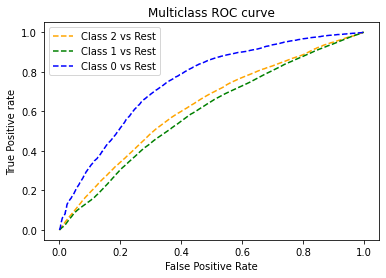

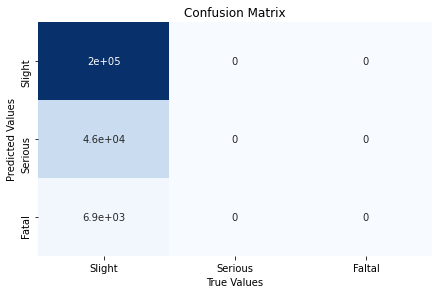

In [42]:
fit_pred_mod(1,1)

(750000, 7)
model score: 0.788
              precision    recall  f1-score   support

           0       0.79      0.99      0.88    197488
           1       0.34      0.02      0.03     45657
           2       0.49      0.04      0.08      6855

    accuracy                           0.79    250000
   macro avg       0.54      0.35      0.33    250000
weighted avg       0.70      0.79      0.70    250000



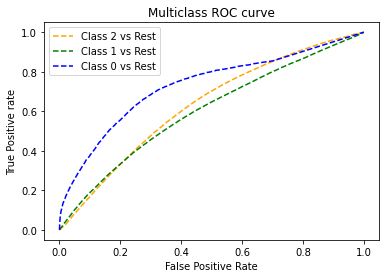

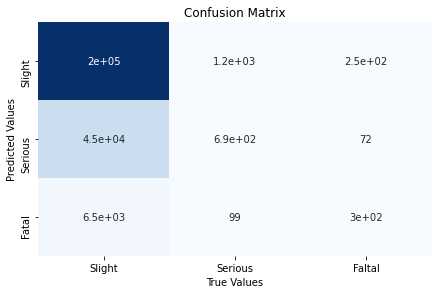

In [44]:
fit_pred_mod(2,1)

(750000, 7)
model score: 0.788
              precision    recall  f1-score   support

           0       0.79      0.99      0.88    197488
           1       0.35      0.02      0.04     45657
           2       0.48      0.05      0.09      6855

    accuracy                           0.79    250000
   macro avg       0.54      0.35      0.33    250000
weighted avg       0.70      0.79      0.70    250000



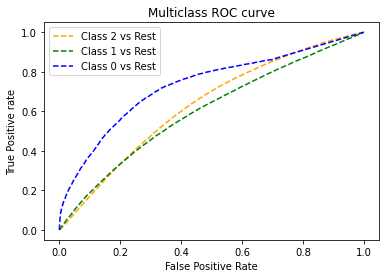

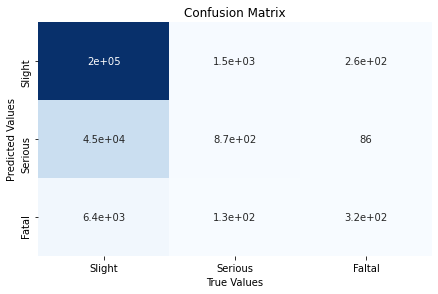

In [45]:
fit_pred_mod(3,1)

(750000, 7)
model score: 0.787
              precision    recall  f1-score   support

           0       0.79      0.99      0.88    197488
           1       0.33      0.02      0.04     45657
           2       0.45      0.05      0.09      6855

    accuracy                           0.79    250000
   macro avg       0.52      0.35      0.34    250000
weighted avg       0.70      0.79      0.70    250000



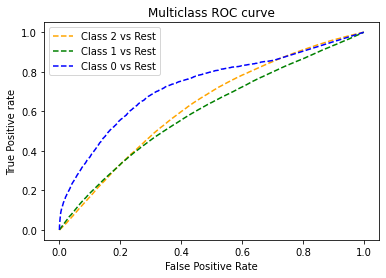

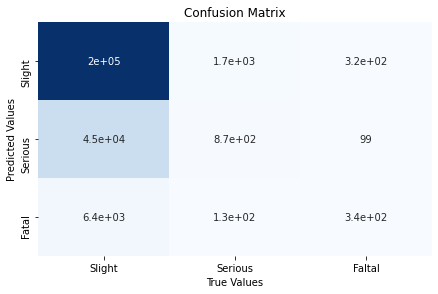

In [46]:
fit_pred_mod(4,1)

(750000, 7)
model score: 0.790


C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.79      1.00      0.88    197488
           1       0.00      0.00      0.00     45657
           2       0.00      0.00      0.00      6855

    accuracy                           0.79    250000
   macro avg       0.26      0.33      0.29    250000
weighted avg       0.62      0.79      0.70    250000



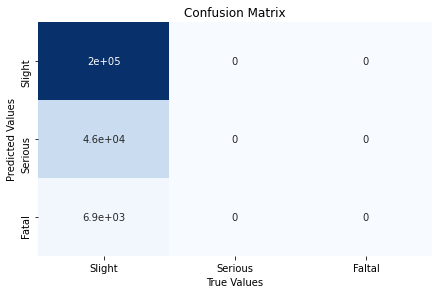

In [47]:
fit_pred_mod(5,1)

(750000, 7)
model score: 0.762
              precision    recall  f1-score   support

           0       0.80      0.94      0.86    197488
           1       0.25      0.08      0.13     45657
           2       0.39      0.04      0.07      6855

    accuracy                           0.76    250000
   macro avg       0.48      0.36      0.35    250000
weighted avg       0.69      0.76      0.71    250000



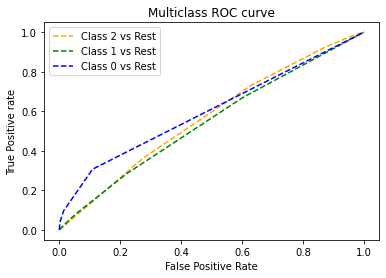

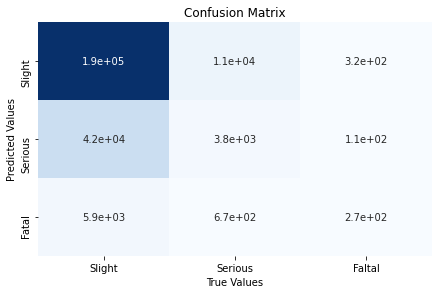

In [48]:
fit_pred_mod(6,1)

(750000, 7)
model score: 0.790


C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.79      1.00      0.88    197488
           1       0.00      0.00      0.00     45657
           2       0.00      0.00      0.00      6855

    accuracy                           0.79    250000
   macro avg       0.26      0.33      0.29    250000
weighted avg       0.62      0.79      0.70    250000



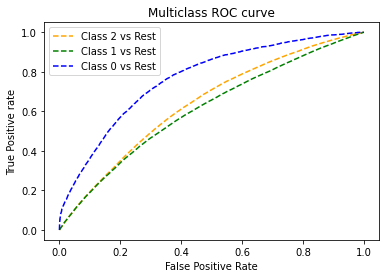

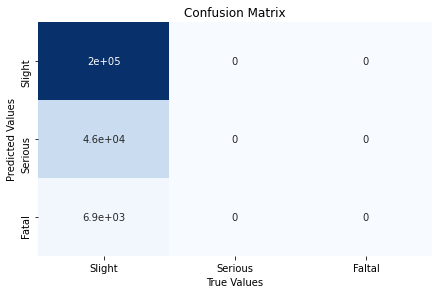

In [49]:
fit_pred_mod(7,1)

# Evaluate our models with balanced data

#### *Handling manually imbalance data*

In [50]:
df_balanced.Accident_Severity.value_counts()

1    4690781
2    1081509
3     165945
Name: Accident_Severity, dtype: int64

In [51]:
df_fatal = df_balanced[df_balanced['Accident_Severity']==  3 ].sample(165945)
df_slight = df_balanced[df_balanced['Accident_Severity']== 1].sample(165945)
df_serious = df_balanced[df_balanced['Accident_Severity']== 2].sample(165945)

In [52]:
df_balanced_m = pd.concat([df_fatal, df_serious,df_slight], axis=0)

In [53]:
df_balanced_m.Accident_Severity.value_counts(normalize=True)

1    0.333333
2    0.333333
3    0.333333
Name: Accident_Severity, dtype: float64

In [61]:
df_balanced_m.dtypes

Accident_Severity              int64
Day_of_Week                    int32
Speed_limit                    int32
Daytime                        int32
Road_Surface_Conditions_2      int32
Weather_Conditions_2           int32
Light_Conditions_2             int32
Vehicle_Type                   int32
Sex_of_Driver                  int32
Age_Band_of_Driver             int32
Engine_Capacity_(CC)         float64
Age_of_Vehicle               float64
dtype: object

In [55]:
cat,num = vtypes(df_balanced_m)

In [56]:
df_balanced_m = lencoder(df_balanced_m)

In [85]:
X,y =  target_features(df_balanced_m)

In [86]:
df_balanced_m

,Accident_Severity,Day_of_Week,Speed_limit,Daytime,Road_Surface_Conditions_2,Weather_Conditions_2,Light_Conditions_2,Vehicle_Type,Sex_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Age_of_Vehicle
1846698,2,4,16,4,1,1,1,10,0,6,4.041393,1.000000
3364430,2,2,16,2,1,1,1,7,0,8,3.112270,0.698970
2492977,2,0,20,2,1,1,1,7,1,8,3.142389,0.698970
2114920,2,6,20,4,1,1,1,7,0,5,3.202216,0.602060
5862350,2,3,16,2,1,1,0,7,0,5,3.203033,1.146128
...,...,...,...,...,...,...,...,...,...,...,...,...
3254620,0,1,7,0,1,1,1,7,1,6,3.112940,0.778151
2474089,0,3,7,2,0,0,1,7,0,10,3.243782,0.698970
2912704,0,0,16,1,0,0,1,7,0,8,3.250664,0.903090
24043,0,3,16,1,0,1,1,7,1,5,3.048053,0.698970


In [60]:
X = calculate_vif(X)

dropping 'Engine_Capacity_(CC)' at index: 9
dropping 'Vehicle_Type' at index: 6
dropping 'Age_Band_of_Driver' at index: 7
dropping 'Weather_Conditions_2' at index: 4
Remaining variables:
Index(['Day_of_Week', 'Speed_limit', 'Daytime', 'Road_Surface_Conditions_2',
       'Light_Conditions_2', 'Sex_of_Driver', 'Age_of_Vehicle'],
      dtype='object')


In [92]:
ohe = OneHotEncoder(sparse=False)
#y_reshape =  y.reshape(-1,1)
y_ohe = ohe.fit_transform(y.values.reshape(-1,1))

In [100]:
X_train, X_test, y_train, y_test = split(X,y)

In [101]:
features_col = list(X.columns)
features_col
cat=[]
num=[]
for i in features_col:
    if i == 'Age_of_Vehicle' or i =='Engine_Capacity_(CC)':
        num.append(i)
    else:
        cat.append(i)

(373376, 11)
model score: 0.482
              precision    recall  f1-score   support

           0       0.50      0.59      0.54     41454
           1       0.39      0.18      0.25     41708
           2       0.50      0.67      0.57     41297

    accuracy                           0.48    124459
   macro avg       0.46      0.48      0.45    124459
weighted avg       0.46      0.48      0.45    124459



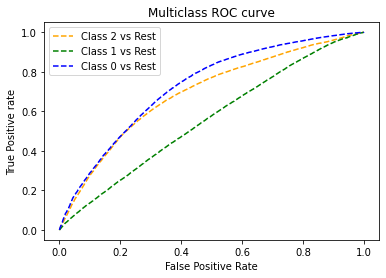

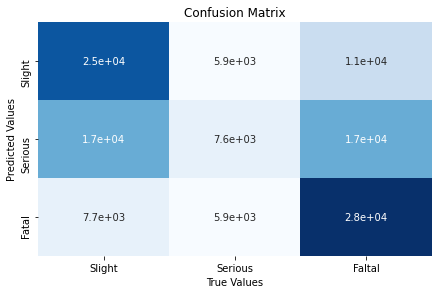

In [102]:
fit_pred_mod(1,2)

(373376, 11)
model score: 0.601
              precision    recall  f1-score   support

           0       0.53      0.49      0.51     41454
           1       0.52      0.48      0.50     41708
           2       0.72      0.83      0.77     41297

    accuracy                           0.60    124459
   macro avg       0.59      0.60      0.59    124459
weighted avg       0.59      0.60      0.59    124459



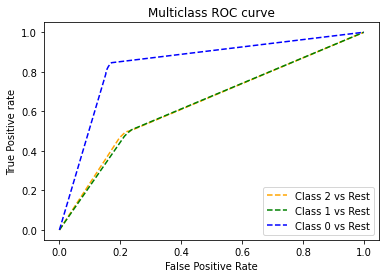

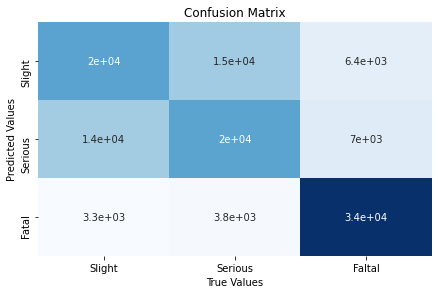

In [104]:
fit_pred_mod(2,2)

(373376, 11)
model score: 0.623
              precision    recall  f1-score   support

           0       0.56      0.54      0.55     41454
           1       0.54      0.49      0.52     41708
           2       0.75      0.84      0.79     41297

    accuracy                           0.62    124459
   macro avg       0.61      0.62      0.62    124459
weighted avg       0.61      0.62      0.62    124459



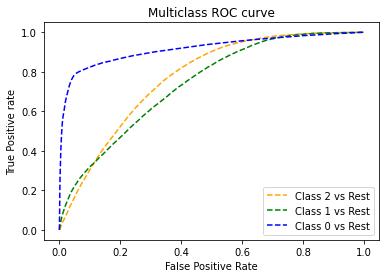

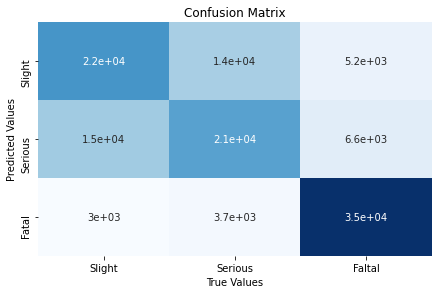

In [105]:
fit_pred_mod(3,2)

(373376, 11)
model score: 0.615
              precision    recall  f1-score   support

           0       0.55      0.55      0.55     41454
           1       0.53      0.48      0.50     41708
           2       0.75      0.82      0.78     41297

    accuracy                           0.61    124459
   macro avg       0.61      0.62      0.61    124459
weighted avg       0.61      0.61      0.61    124459



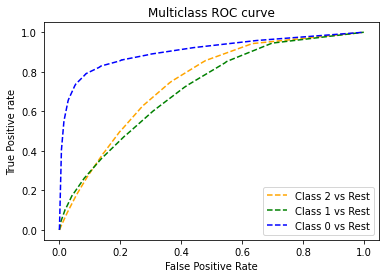

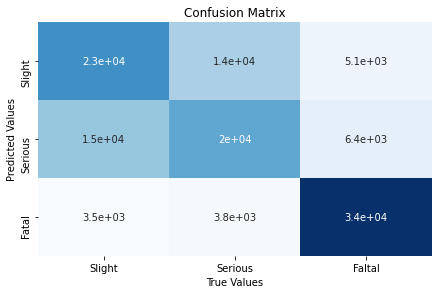

In [106]:
fit_pred_mod(4,2)

C:\Users\hexen\anaconda3\envs\tfm\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



(373376, 11)
model score: 0.480
              precision    recall  f1-score   support

           0       0.48      0.65      0.55     41454
           1       0.41      0.08      0.14     41708
           2       0.49      0.71      0.58     41297

    accuracy                           0.48    124459
   macro avg       0.46      0.48      0.42    124459
weighted avg       0.46      0.48      0.42    124459



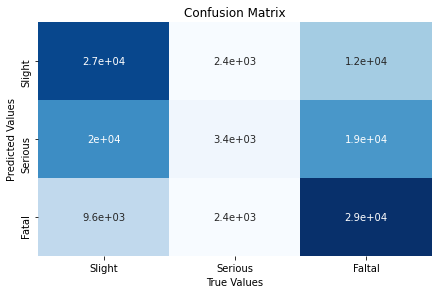

In [107]:
fit_pred_mod(5,2)

(373376, 11)
model score: 0.523
              precision    recall  f1-score   support

           0       0.48      0.53      0.51     41454
           1       0.45      0.39      0.42     41708
           2       0.63      0.65      0.64     41297

    accuracy                           0.52    124459
   macro avg       0.52      0.52      0.52    124459
weighted avg       0.52      0.52      0.52    124459



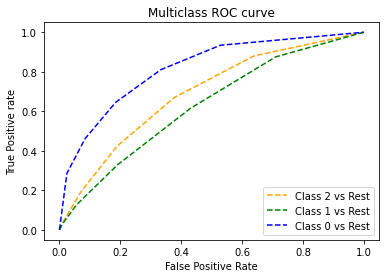

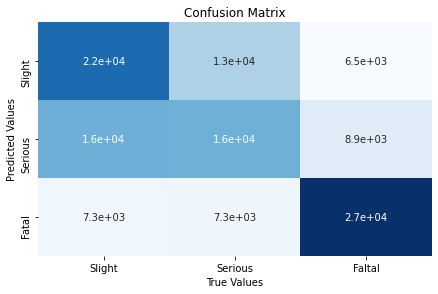

In [108]:
fit_pred_mod(6,2)

(373376, 11)
model score: 0.493
              precision    recall  f1-score   support

           0       0.53      0.53      0.53     41454
           1       0.40      0.24      0.30     41708
           2       0.51      0.71      0.59     41297

    accuracy                           0.49    124459
   macro avg       0.48      0.49      0.47    124459
weighted avg       0.48      0.49      0.47    124459



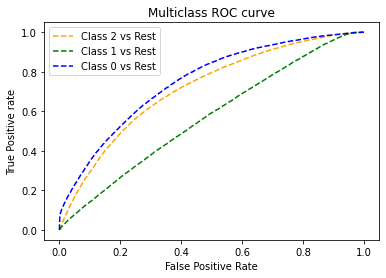

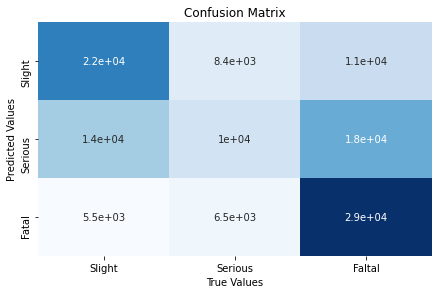

In [109]:
fit_pred_mod(7,2)

# SMOTE OVERSAMPLING

Our last metrics with imbalanced data were bad and with manually balanced data improved a little , so we will try with Oversample technique for handling imbalanced data:


<img src="https://i0.wp.com/dataaspirant.com/wp-content/uploads/2020/08/10-oversampling.png?resize=768%2C407&ssl=1" alt="image info" width="500" />

<img src="https://i1.wp.com/dataaspirant.com/wp-content/uploads/2020/08/17-undersampling.png?resize=768%2C399&ssl=1" alt="image info" width="500" />

[Handling Imbalanced data with python](https://dataaspirant.com/handle-imbalanced-data-machine-learning/#t-1596963627856)

In [121]:
from imblearn.over_sampling import SMOTE

In [122]:
from collections import Counter

In [130]:
df_balanced.Accident_Severity.sample(1000000).value_counts()
df_balanced_sample = df_balanced.sample(1000000)

In [131]:
cat,num = vtypes(df_balanced_sample)
df_balanced_m = lencoder(df_balanced_sample)
X,y =  target_features(df_balanced_sample)
X = calculate_vif(X)
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = split(X,y)
features_col = list(X.columns)
features_col
cat=[]
num=[]
for i in features_col:
    if i == 'Age_of_Vehicle' or i =='Engine_Capacity_(CC)':
        num.append(i)
    else:
        cat.append(i)

dropping 'Engine_Capacity_(CC)' at index: 9
dropping 'Vehicle_Type' at index: 6
dropping 'Age_Band_of_Driver' at index: 7
dropping 'Weather_Conditions_2' at index: 4
Remaining variables:
Index(['Day_of_Week', 'Speed_limit', 'Daytime', 'Road_Surface_Conditions_2',
       'Light_Conditions_2', 'Sex_of_Driver', 'Age_of_Vehicle'],
      dtype='object')


In [128]:
oversample = SMOTE()
X_smote, y_smote = oversample.fit_resample(X, y)

KeyboardInterrupt: 

(1776924, 7)
model score: 0.488
              precision    recall  f1-score   support

           0       0.50      0.60      0.55    197100
           1       0.38      0.22      0.28    197818
           2       0.53      0.64      0.58    197390

    accuracy                           0.49    592308
   macro avg       0.47      0.49      0.47    592308
weighted avg       0.47      0.49      0.47    592308



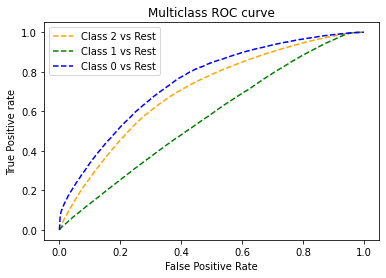

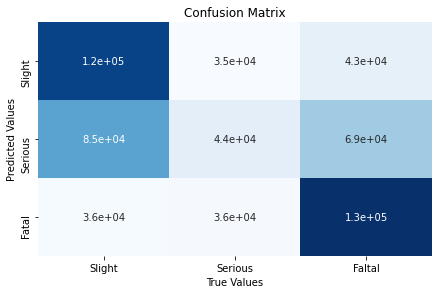

In [138]:
fit_pred_mod(7,3)